Víctor González Kullmann u161806<br>
Albert Baito Pané u161812

## PART 3: Ranking


In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
import json
import pycountry
import re
import string
#2
import collections
from collections import defaultdict
from array import array
import time
import numpy as np
from numpy import linalg as la
import math
import pandas as pd
import math
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [2]:
#create a function to load the desired file containing the tweets
def load_data(file_name):
    with open(file_name) as f:
        tweets=json.load(f)
    return tweets
        
tweets = load_data("dataset_tweets_WHO.txt")

In [3]:
#function that transforms the iso lenguage in the complete name
def iso_leng_translate(leng):
    return pycountry.languages.get(alpha_2=leng).name.lower()

In [4]:
#get all the languages in the tweets of the datasets and get the stopwords of that language if available
def create_stopword_dict(tweets):
    #get languages
    lang=[]
    for i in range(len(tweets)):
        lang.append((tweets[str(i)]['lang']))
    languages = set(lang)
    print(languages)
    
    #search for the stopwords and save them in a dictionary for later usage
    lang_dict = {}
    for i in languages:     
        try:
            #transform ISO lenguage in complete name for convenience
            lang_dict [i] = set(stopwords.words(iso_leng_translate(i)))
            
        #if we don't have a stopwords available for that lenguage we just skip
        except:
            continue
        
        
    return lang_dict

stopwords_bylang = create_stopword_dict(tweets)

{'fr', 'en', 'ru', 'und', 'es', 'ja', 'tl', 'de', 'ar', 'ps', 'in', 'uk'}


In [5]:
def clean_data(tweet, stopwordsByLan):
    
    #get the tweet text
    og_tweet_text = (tweet['full_text']) 

    #lowercase to uniform format and split to get words
    og_tweet_text = og_tweet_text.lower()   
    og_tweet_text = og_tweet_text.split()

    #create our pattern to avoid removing #

    #remove punctuation
    tweet_text=[]
    for word in og_tweet_text:
        #maintain the links in the correct format
        if "https" not in word:
            #delete all punctuation conserving the # and @(in tweets are meaninguful)
            word = re.sub(r'[^\w\s#@]','', word)
            word = re.sub(r'_','',word)

        if word:
            tweet_text.append(word) 


    #get lenguage to filter stpowords
    tweet_lang = tweet['lang'].lower()
    #check availability of stopwors dict
    if tweet_lang in stopwordsByLan.keys():
        #if possible filter stopwords
        stop_words = set(stopwordsByLan[tweet_lang])
        clean_text = []
        for word in tweet_text:
            if word not in stop_words:
                clean_text.append(word)

    #if stopwords are not available in some lenguage just let them 
    else:
        clean_text = tweet_text    


    #stem the words with the correct format for each lenguage
    try:
        stemmer = SnowballStemmer(iso_leng_translate(tweet_lang))
        clean_text = [stemmer.stem(word) for word in clean_text]

    except:
        pass   
        
    return clean_text

In [6]:
#function created to search for tweet id of a concrete lenguage
def tweet_lenguageSearcher(tweets, leng):
    for i in range(len(tweets)):
        if (tweets[str(i)]['lang']) == leng:
            print(tweets[str(i)]['id'])

In [7]:
tweet_lenguageSearcher(tweets, "es")

1448163383493136385
1447422682711068673
1447421758437564417
1447421622235942912
1446492798493003779
1437873802952708097
1437873628792639490
1436055322376949761
1436055263312818176
1426242406853353474
1425836042599374848
1425212438354571265
1424986407857238034
1423905220250243074
1423662605516804097
1422204917876461572
1421895908669763586
1411320867456434177
1409244087962775557


In [8]:
#function to plot the og tweet to check for the data processing correctness
def tweet_Printer(tweets, id):
    for i in range(len(tweets)):
            if (tweets[str(i)]['id']) == id:
                print(tweets[str(i)]['full_text'])

In [9]:
tweet_Printer(tweets, 1426242406853353474)

RT @Ops_Paraguay: 👥La salud comunitaria está en el centro de la vacunación contra la COVID-19 en comunidades indígenas de Paraguay
➕INFO👉:…


In [10]:
#create inverted index
def create_index(tweets, stopwordsByLan):
    """
    Impleent the inverted index
    
    Argument:
    collection of tweets
    
    Returns:
    index - the inverted index containing terms as keys and the corresponding 
    list of tweets these keys appears in (and the positions) as values.
    tf - normalized term frequency for each term in each tweet
    idf - inverse document frequency of each term
    """
    
    index = defaultdict(list) 
    
    tf = defaultdict(list)        #term frequencies of terms in tweets 
    df = defaultdict(int)         #tweet frequencies of terms in the collection
    idf = defaultdict(float)
    
    N = len(tweets)
    
    for tweet_num, tweet in tweets.items(): 
        #get the id of the tweet
        tweet_id = tweet["id"]
        #get the terms cleaned 
        terms = clean_data(tweet, stopwordsByLan)
                
        termdictTweet = {}

        for position, term in enumerate(terms): # terms in the tweet
            try:
                # if the term is already in the index for the current tweet
                # append the position to the corrisponding list
                
                termdictTweet[term][tweet_id].append(position)  
            except:
                # Add the new term as dict key and initialize the array of positions and add the position
                termdictTweet[term]=[tweet_id, array('I',[position])] #'I' indicates unsigned int (int in python)
        
        
        #normalize term frequencies
        # Compute the denominator to normalize term frequencies
        # norm is the same for all terms of a tweet.
        norm = 0
        for term, posting in termdictTweet.items(): 
            # posting is a list containing tweet_id and the list of positions for current term in current tweet: 
            # posting ==> [tweet_id, [list of positions]] 
            # you can use it to inferr the frequency of current term.
            norm+=len(posting[1])**2
        
        norm = math.sqrt(norm)


        #calculate the tf (dividing the term frequency by the above computed norm) and df weights
        for term, posting in termdictTweet.items():     
            # append the tf for current term (tf = term frequency in current tweet/norm)
            tf[term].append(np.round(len(posting[1])/norm ,4))  
            #increment the document frequency of current term (number of tweets containing the current term)
            df[term] += 1  # increment df for current term
        
        # Compute idf 
        for term in df:
            idf[term] = np.round(np.log(float(N/df[term])),4)
        
        #merge the current tweet index with the main index
        for termpage, postingpage in termdictTweet.items():
            index[termpage].append(postingpage)
                      
                    
    return index, tf, idf

In [11]:
start_time = time.time()
inverted_index, tf, idf= create_index(tweets, stopwords_bylang)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time,2)))

Total time to create the index: 89.41 seconds


In [12]:
def rankTweetsTFIDF(terms, tweets_ids, index, idf, tf):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    tweets_ids -- list of tweet ids, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    titleIndex -- mapping between page id and page title
    
    Returns:
    resultScores --  List of ranked scores of tweets
    resultTweets --  List of ranked tweet ids
    """
        
    # I'm interested only on the element of the tweetVector corresponding to the query terms 
    # The remaing elements would became 0 when multiplied to the queryVector
    tweetVectors = defaultdict(lambda: [0]*len(terms))
    queryVector = [0]*len(terms)    

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms) # get the frequency of each term in the query. 
        
    query_norm = la.norm(list(query_terms_count.values()))
    
    for termIndex, term in enumerate(terms): #termIndex is the index of the term in the query
        if term not in index:
            continue
                    
        ## Compute tf*idf(normalize tf as done with tweets)
        queryVector[termIndex]= query_terms_count[term]/query_norm * idf[term] 

        # Generate tweetVectors for matching tweets
        for tweetIndex, (tweet_id, postings) in enumerate(index[term]):
            
            
            if tweet_id in tweets_ids:
                tweetVectors[tweet_id][termIndex] = tf[term][tweetIndex] * idf[term]

    # calculate the score of each tweet
    # compute the cosine similarity between queyVector and each tweetVector:
        
    tweetScores = [ [np.dot(curTweetVec, queryVector), tweet_id] for tweet_id, curTweetVec in tweetVectors.items() ]
    tweetScores.sort(reverse=True)
    resultTweets = [x[1] for x in tweetScores]
    resultScores = [x[0] for x in tweetScores]

    if len(resultTweets) == 0:
        print("No results found, try again")
        
    #return rank punctuation and ids
    return resultScores, resultTweets

In [13]:
def hashtagsFreq(tweets):
    hashtags = []
    for t in tweets.values():
        for hashtag in t["entities"]["hashtags"]:
            hashtags.append("#"+hashtag["text"])
    hashcount = collections.Counter(hashtags)
    hashnorm = la.norm(list(hashcount.values()))
    for h, c in hashcount.items():
        hashcount[h] = c/hashnorm
    return hashcount


In [14]:
def get_hashtags(tweet):
    hashtags = list()
    for hashtag in tweet["entities"]["hashtags"]:
        hashtags.append("#"+hashtag["text"])
    return hashtags

In [15]:
def rankTweetsOurs(terms, tweets_ids, index, idf, tf, tweets):
    """
    Perform the ranking of the results of a search based on the tf-idf weights
    
    Argument:
    terms -- list of query terms
    tweets_ids -- list of tweet ids, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    titleIndex -- mapping between page id and page title
    
    Returns:
    resultScores --  List of ranked scores of tweets
    resultTweets --  List of ranked tweet ids
    """
    #Apply TF-IDF scoring
    tweetVectors = defaultdict(lambda: [0]*len(terms))
    queryVector = [0]*len(terms)    
    query_terms_count = collections.Counter(terms)
    query_norm = la.norm(list(query_terms_count.values()))
    for termIndex, term in enumerate(terms): 
        if term not in index:
            continue
        queryVector[termIndex]= query_terms_count[term]/query_norm * idf[term] 
        for tweetIndex, (tweet_id, postings) in enumerate(index[term]):            
            if tweet_id in tweets_ids:
                tweetVectors[tweet_id][termIndex] = tf[term][tweetIndex] * idf[term]    
    TFIDFScores = [ [np.dot(curTweetVec, queryVector), tweet_id] for tweet_id, curTweetVec in tweetVectors.items() ]
    
    
    #Once we have the scoring of TF-IDF apply variations to the ranking
    
    #Get all the tweet data from the tweet_ids 
    query_tweets = {}
    for t in tweets.values():
        if (t['id']) in tweets_ids:
            query_tweets[t['id']]=t
            
    #Look for different data to involve popularity
    #Get likes and retweets count, and also the ratio divided by its number of followers
    likes_count = []
    likesByFollow = []
    retweets_count = []
    retweetsByFollow = []

    
    for idt in tweets_ids:
        tw = query_tweets[idt]
        likes_count.append(tw["favorite_count"])
        likesByFollow.append(tw["favorite_count"]/tw["user"]["followers_count"])
        retweets_count.append(tw["retweet_count"])
        retweetsByFollow.append(tw["retweet_count"]/tw["user"]["followers_count"]) 
        
    
    #Normalize the likes and retweets among all the query output tweets
    likesnorm = la.norm(likes_count)
    retnorm = la.norm(retweets_count)
    likes_norma = [float(r/likesnorm) for r in likes_count]
    retweets_norma = [float(r/retnorm) for r in retweets_count]
    
    
    #Take care of the hsahtags freq
    hashfreq = hashtagsFreq(tweets)
    
    #Calculate the ponderation of the hashtags, we want to undervaluate tweets that add to much hashtags for spam
    #To do so we calculate 1/num of hashtags to add to the score
    #Also if it has a trend hashtag need to increase its score
    
    nhash_ponderation = []
    hashfreq_bonus = []
    for idt in tweets_ids:
        tw = query_tweets[idt]
        hashtags = get_hashtags(tw)
        
        #get the num of hashtags
        n_hash = len(hashtags)
        nhash_ponderation.append(1/n_hash)
        
        freqs=[]
        for h in hashtags:
            #get the frequency of hashtags
            freqs.append(hashfreq[h])
        
        #if it has a hastag of bigg frequency add it frequency to the score
        if (np.max(freqs)>=0.6):
            hashfreq_bonus.append(np.max(freqs))
        else:
            hashfreq_bonus.append(0)
        
        
    
    #Select every stat weight in the popularity score

    likes = 0.35
    rets = 0.35
    l_f = 0.05
    r_f = 0.05
    nhsh = 0.15
    fhsh = 0.05
    

    pop_scores = {}
    listids = list(tweets_ids)
    for x in range(len(listids)):
        pop_scores[listids[x]] = likes*likes_norma[x]+ rets*retweets_norma[x] + l_f*likesByFollow[x] + r_f*retweetsByFollow[x] + nhsh*nhash_ponderation[x] + fhsh*hashfreq_bonus[x]
    
                                     
    #select the value of tfid and popularity scores in the final score
    tfidfs = 0.3
    pops = 0.7
    
    tfidfnorm = la.norm([r[0] for r in TFIDFScores])
    popsnorm = la.norm(list(pop_scores.values()))
    #normalize to reduce the difference in scoring in both methods
   
    tweetScores = [ [np.dot(curTweetVec, queryVector)/tfidfnorm*tfidfs + pops*pop_scores[tweet_id]/popsnorm, tweet_id] for tweet_id, curTweetVec in tweetVectors.items() ]
    
    tweetScores.sort(reverse=True)

    
    resultTweets = [x[1] for x in tweetScores]
    resultScores = [x[0] for x in tweetScores]
    
    if len(resultTweets) == 0:
        print("No results found, try again")
        
    #return rank punctuation and ids
    return resultScores, resultTweets

In [16]:
def trainWord2VecModel(tweets, stopwordsByLan):
    
    #create our model with the words of the tweets
    sentences=[]
    for tweet in tweets.values():
        sentences.append(clean_data(tweet, stopwordsByLan))
       
       
    #build the model parameters  
    model = Word2Vec(min_count=1, window=5, vector_size=300, workers=4)
    #build vocabulary table
    model.build_vocab(sentences, progress_per=100)
    #train the model
    model.train(sentences, total_examples=model.corpus_count, epochs=30, report_delay=1)
    
    return model

model = trainWord2VecModel(tweets, stopwords_bylang)

In [17]:
def top20ByWord2Vec(query, tweet_ids, index, tweets, stopwordsByLan, word2vec_model):
    
    #calculate tweet2vec by averaging its words
    tweetVectors = {}
    for ids in tweet_ids:
        for t in tweets.values():
            if t["id"]==ids:
                twords = clean_data(t, stopwordsByLan)
        
        wordspresent = [word for word in twords if word in word2vec_model.wv.index_to_key]
        vector = np.mean(word2vec_model.wv[wordspresent], axis=0)
        tweetVectors[ids] = vector
                
            
    
    #calculate query vector by avg of its words
    wordspresent = [word for word in query if word in word2vec_model.wv.index_to_key]
    queryVector =  np.mean(word2vec_model.wv[wordspresent], axis=0)
    
    #calculate cosine similarity  
    
    tweetScores = [ [np.dot(curTweetVec, queryVector), tweet_id] for tweet_id, curTweetVec in tweetVectors.items() ]
    tweetScores.sort(reverse=True)
    resultTweets = [x[1] for x in tweetScores][:20]
    resultScores = [x[0] for x in tweetScores][:20]
    
    return  resultScores, resultTweets

In [18]:
def tweet_Searcher(tweets, id):
    for tweet in tweets.values():
            if (tweet['id']) == id:
                #return "Url: " + "twitter.com/"+str(tweet["user"]["id"])+"/status/"+tweet['id_str']
                return "Tweet: " + str(tweet['full_text']) + "|" + "Username: " + str(tweet["user"]["name"]) + "|" + "Date: "+ str(tweet["created_at"]) + "|" + "Hashtags: " + ' '.join(get_hashtags(tweet)).strip() + "|" + "Likes: " +  str(tweet["favorite_count"]) + "|" + "Retweets: "+ str(tweet["retweet_count"]) + "|" + "Url: " + "twitter.com/"+str(tweet["user"]["id"])+"/status/"+tweet['id_str']

In [19]:
def query_search(query, index, stopwordsByLan, tweets, tf, idf, scores, model, word2vec_model):
    '''
    As we are working with conjunctive queries. 
    The output is either the needed data of tweets that contain all of the query terms, if scores is False, or 
    the tweet ids and the scores of tweets that contain all query terms if scores is True.
    '''
    query = clean_data(query, stopwordsByLan)
    tweet_ids = []
    for pos, term in enumerate(query):
        try: 
            #store the ids of Tweets that contain "term"                        
            termTweets = [posting[0] for posting in index[term]]
            #the first term tweet ids are aved to compute intersection with later terms
            if pos == 0:
                tweet_ids = set(termTweets)
                
            else:  
                tweet_ids = tweet_ids.intersection(termTweets)
        except:
            #term is not in index stop searching
            print("This query has no result in the collection")
            return 0
    
    if model==0:      
        #rank by our score
        rank_scores, ranked_tweets = rankTweetsOurs(query, tweet_ids, index, idf, tf, tweets)
    elif model==1:
        #rank by word2vec
        rank_scores, ranked_tweets = top20ByWord2Vec(query, tweet_ids, index, tweets,stopwordsByLan, word2vec_model)
    
    else:
        #rank by tf-idf
        rank_scores, ranked_tweets = rankTweetsTFIDF(query, tweet_ids, index, idf, tf)
    
    
    #search for the information of the selected tweets
    return_list=[]
    for tweet_id in ranked_tweets:
        return_list.append(tweet_Searcher(tweets, tweet_id))
    
    if scores:
        return rank_scores, ranked_tweets
    
    return return_list

In [20]:
query = {"full_text":"covid19 pandemic", "lang":"en"}
tweets_answersTFIDF = query_search(query, inverted_index, stopwords_bylang, tweets, tf, idf, False, 2, model)
tweets_answersOURS = query_search(query, inverted_index, stopwords_bylang, tweets, tf, idf, False, 0, model)
top = 10
print("Query: ", query["full_text"])
print("\n======================\nSample of {} results out of {} for the seached query, using ranking algorithm TF-IDF:\n".format(top, len(tweets_answersTFIDF)))
for t_id in tweets_answersTFIDF[:top] :
    print(t_id)
    print("\n")

print("Query: ", query["full_text"])
print("\n======================\nSample of {} results out of {} for the seached query, using ranking algorithm OURS:\n".format(top, len(tweets_answersOURS)))
for t_id in tweets_answersOURS[:top] :
    print(t_id)
    print("\n")

Query:  covid19 pandemic

Sample of 10 results out of 8 for the seached query, using ranking algorithm TF-IDF:

Tweet: RT @UNICEF: Your guide to breastfeeding safely during the COVID-19 pandemic. 

#WorldBreastfeedingWeek https://t.co/8EaLDselmn|Username: World Health Organization (WHO)|Date: Sun Aug 01 16:29:25 +0000 2021|Hashtags: #WorldBreastfeedingWeek|Likes: 0|Retweets: 278|Url: twitter.com/14499829/status/1421870697094205445


Tweet: 💉💉💉💉
💉💉💉💉
💉💉💉💉
💉💉💉💉
💉💉💉💉                 💉💉💉💉
💉💉💉💉                 💉💉💉💉

COVID-19 vaccines     COVID-19 vaccines
in 10 countries             in the rest of the 🌍

#VaccinEquity is 🗝️ to ending the pandemic, together!

#WorldEmojiDay|Username: World Health Organization (WHO)|Date: Sat Jul 17 16:24:23 +0000 2021|Hashtags: #VaccinEquity #WorldEmojiDay|Likes: 3486|Retweets: 1517|Url: twitter.com/14499829/status/1416433609091653633


Tweet: RT @WHOAFRO: 📺 LIVE: @WHOAFRO press briefing on the #COVID19 pandemic, genome sequencing and COVID-19 variants in #A

### 5 Queries with TFIDF ranking (part2)

In [21]:
#wirte the queries respecting the format of the cleaner
#specify the lang of the query to stem it and remove stopwords in a correct form
query = {"full_text":"covid19 pandemic", "lang":"en"}
tweets_answers = query_search(query, inverted_index, stopwords_bylang, tweets, tf, idf, False, 2, model)    
top = 10
print("Query: ", query["full_text"])
print("\n======================\nSample of {} results out of {} for the seached query:\n".format(top, len(tweets_answers)))
for t_id in tweets_answers[:top] :
    print(t_id)
    print("\n")
    

Query:  covid19 pandemic

Sample of 10 results out of 8 for the seached query:

Tweet: RT @UNICEF: Your guide to breastfeeding safely during the COVID-19 pandemic. 

#WorldBreastfeedingWeek https://t.co/8EaLDselmn|Username: World Health Organization (WHO)|Date: Sun Aug 01 16:29:25 +0000 2021|Hashtags: #WorldBreastfeedingWeek|Likes: 0|Retweets: 278|Url: twitter.com/14499829/status/1421870697094205445


Tweet: 💉💉💉💉
💉💉💉💉
💉💉💉💉
💉💉💉💉
💉💉💉💉                 💉💉💉💉
💉💉💉💉                 💉💉💉💉

COVID-19 vaccines     COVID-19 vaccines
in 10 countries             in the rest of the 🌍

#VaccinEquity is 🗝️ to ending the pandemic, together!

#WorldEmojiDay|Username: World Health Organization (WHO)|Date: Sat Jul 17 16:24:23 +0000 2021|Hashtags: #VaccinEquity #WorldEmojiDay|Likes: 3486|Retweets: 1517|Url: twitter.com/14499829/status/1416433609091653633


Tweet: RT @WHOAFRO: 📺 LIVE: @WHOAFRO press briefing on the #COVID19 pandemic, genome sequencing and COVID-19 variants in #Africa. Dr @MoetiTshidi…|Username

In [22]:
#wirte the queries respecting the format of the cleaner
#specify the lang of the query to stem it and remove stopwords in a correct form
query = {"full_text":"vaccine africa", "lang":"en"}
tweets_answers = query_search(query, inverted_index, stopwords_bylang, tweets, tf, idf, False, 2, model)    
top = 10
print("Query: ", query["full_text"])
print("\n======================\nSample of {} results out of {} for the seached query:\n".format(top, len(tweets_answers)))
for t_id in tweets_answers[:top] :
    print(t_id)
    print("\n")

Query:  vaccine africa

Sample of 10 results out of 17 for the seached query:

Tweet: RT @DrTedros: Over 5.7 billion #COVID19 vaccine doses have been administered globally, but only 2% were given in Africa. This hurts all of…|Username: World Health Organization (WHO)|Date: Wed Sep 15 10:32:25 +0000 2021|Hashtags: #COVID19|Likes: 0|Retweets: 193|Url: twitter.com/14499829/status/1438088306965762048


Tweet: .@DrTedros and the group of global health leaders issued an urgent call to accelerate #COVID19 vaccination globally and in Africa in particular 👉 https://t.co/2hTLpRJ2xH 

#VaccinEquity

https://t.co/U56PfHxeug|Username: World Health Organization (WHO)|Date: Tue Sep 14 19:47:01 +0000 2021|Hashtags: #COVID19 #VaccinEquity|Likes: 207|Retweets: 69|Url: twitter.com/14499829/status/1437865487879319561


Tweet: @DrTedros "In low-income countries, most of which are in Africa, less than 2% of adults are fully vaccinated, compared with almost 50% in high‑income countries"-@DrTedros #VaccinEqui

In [23]:
#wirte the queries respecting the format of the cleaner
#specify the lang of the query to stem it and remove stopwords in a correct form
query = {"full_text":"climate crisis", "lang":"en"}
tweets_answers = query_search(query, inverted_index, stopwords_bylang, tweets, tf, idf, False, 2, model)    
top = 10
print("Query: ", query["full_text"])
print("\n======================\nSample of {} results out of {} for the seached query:\n".format(top, len(tweets_answers)))
for t_id in tweets_answers[:top] :
    print(t_id)
    print("\n")

Query:  climate crisis

Sample of 10 results out of 6 for the seached query:

Tweet: @DrTedros "The humanitarian system is being pushed to its absolute limit - and beyond - by the climate crisis, natural disasters, conflict and the #COVID19 pandemic"-@DrTedros #WorldHumanitarianDay|Username: World Health Organization (WHO)|Date: Wed Aug 18 13:39:50 +0000 2021|Hashtags: #COVID19 #WorldHumanitarianDay|Likes: 54|Retweets: 23|Url: twitter.com/14499829/status/1427988612717633539


Tweet: It's #WorldHumanitarianDay
 
The climate emergency is a humanitarian crisis.
We must maximise the health benefits of tackling the #ClimateCrisis while avoiding its worst health impacts, and promote climate-resilient health systems everywhere.

👉 https://t.co/cM6yAJX0fE https://t.co/heviFQaWSJ|Username: World Health Organization (WHO)|Date: Thu Aug 19 10:10:30 +0000 2021|Hashtags: #WorldHumanitarianDay #ClimateCrisis|Likes: 262|Retweets: 64|Url: twitter.com/14499829/status/1428298318254415874


Tweet: "Clima

In [24]:
#wirte the queries respecting the format of the cleaner
#specify the lang of the query to stem it and remove stopwords in a correct form
query = {"full_text":"depression", "lang":"en"}
tweets_answers = query_search(query, inverted_index, stopwords_bylang, tweets, tf, idf, False, 2, model)    
top = 10
print("Query: ", query["full_text"])
print("\n======================\nSample of {} results out of {} for the seached query:\n".format(top, len(tweets_answers)))
for t_id in tweets_answers[:top] :
    print(t_id)
    print("\n")

Query:  depression

Sample of 10 results out of 8 for the seached query:

Tweet: RT @Alissonbecker: I am supporting @WHO and @FIFAcom on #WorldMentalHealthDay - let's support each other when we feel depressed. #ReachOut…|Username: World Health Organization (WHO)|Date: Mon Oct 11 04:38:21 +0000 2021|Hashtags: #WorldMentalHealthDay #ReachOut|Likes: 0|Retweets: 88|Url: twitter.com/14499829/status/1447421286871977987


Tweet: RT @WHOMaldives: Some of the life changes that come with #ageing can cause depression 

If you think you might be at risk, this information…|Username: World Health Organization (WHO)|Date: Mon Oct 11 04:41:00 +0000 2021|Hashtags: #ageing|Likes: 0|Retweets: 21|Url: twitter.com/14499829/status/1447421956819664907


Tweet: Think you may have #depression?

#LetsTalk about it. 💚

Follow this thread for symptoms of depression, what you can do and where to seek help. 💚

#WorldMentalHealthDay https://t.co/maqhBmYtEJ|Username: World Health Organization (WHO)|Date: Sun Oct 10 0

In [25]:
#wirte the queries respecting the format of the cleaner
#specify the lang of the query to stem it and remove stopwords in a correct form
query = {"full_text":"vaccination coverage", "lang":"en"}
tweets_answers = query_search(query, inverted_index, stopwords_bylang, tweets, tf, idf, False, 2, model)    
top = 10
print("Query: ", query["full_text"])
print("\n======================\nSample of {} results out of {} for the seached query:\n".format(top, len(tweets_answers)))
for t_id in tweets_answers[:top] :
    print(t_id)
    print("\n")

Query:  vaccination coverage

Sample of 10 results out of 15 for the seached query:

Tweet: "In those countries with low #COVID19 vaccination coverage, terrible scenes of hospitals overflowing are again becoming the norm. 
But no country is out of the woods yet."-@DrTedros|Username: World Health Organization (WHO)|Date: Fri Jul 02 12:52:43 +0000 2021|Hashtags: #COVID19|Likes: 38|Retweets: 23|Url: twitter.com/14499829/status/1410944523119869958


Tweet: @DrTedros "Meanwhile, countries with low vaccine coverage continue to see high case fatality rates"-@DrTedros #VaccinEquity 

https://t.co/uUlxDj6NDY|Username: World Health Organization (WHO)|Date: Wed Sep 08 14:35:48 +0000 2021|Hashtags: #VaccinEquity|Likes: 45|Retweets: 19|Url: twitter.com/14499829/status/1435612842481405953


Tweet: RT @DrTedros: Countries with high coverage are seeing a decoupling of #COVID19 cases &amp; deaths, whereas countries that can't access vaccines…|Username: World Health Organization (WHO)|Date: Sat Aug 14 1

## WORD2VEC TOP 20 FOR QUERIES

In [26]:
queries = [{"full_text":"covid19 pandemic", "lang":"en"}, 
           {"full_text":"vaccine africa", "lang":"en"}, 
           {"full_text":"climate crisis", "lang":"en"}, 
           {"full_text":"depression", "lang":"en"}, 
           {"full_text":"vaccination coverage", "lang":"en"}]

for q in (queries):
    word2vectop20 = query_search(q, inverted_index, stopwords_bylang, tweets, tf, idf, False, 1, model)
    print("Query: ", q["full_text"])
    print("\n======================\nTop 20 results for the seached query, using Word2Vec:\n")
    for t_id in word2vectop20:
        print(t_id)
        print("\n")


Query:  covid19 pandemic

Top 20 results for the seached query, using Word2Vec:

Tweet: 💉💉💉💉
💉💉💉💉
💉💉💉💉
💉💉💉💉
💉💉💉💉                 💉💉💉💉
💉💉💉💉                 💉💉💉💉

COVID-19 vaccines     COVID-19 vaccines
in 10 countries             in the rest of the 🌍

#VaccinEquity is 🗝️ to ending the pandemic, together!

#WorldEmojiDay|Username: World Health Organization (WHO)|Date: Sat Jul 17 16:24:23 +0000 2021|Hashtags: #VaccinEquity #WorldEmojiDay|Likes: 3486|Retweets: 1517|Url: twitter.com/14499829/status/1416433609091653633


Tweet: RT @WHOAFRO: 📺 LIVE: @WHOAFRO media briefing on the #COVID19 pandemic &amp; the global 10% COVID-19 vaccination milestones reached by countries…|Username: World Health Organization (WHO)|Date: Thu Sep 30 10:07:43 +0000 2021|Hashtags: #COVID19|Likes: 0|Retweets: 27|Url: twitter.com/14499829/status/1443517908072730624


Tweet: RT @WHOAFRO: 📺 LIVE: @WHOAFRO press briefing on the #COVID19 pandemic, genome sequencing and COVID-19 variants in #Africa. Dr @MoetiTshidi…|Usern

#WorldMentalHealthDay https://t.co/maqhBmYtEJ|Username: World Health Organization (WHO)|Date: Sun Oct 10 00:06:56 +0000 2021|Hashtags: #depression #LetsTalk #WorldMentalHealthDay|Likes: 231|Retweets: 117|Url: twitter.com/14499829/status/1446990596791541761


Tweet: RT @Alissonbecker: I am supporting @WHO and @FIFAcom on #WorldMentalHealthDay - let's support each other when we feel depressed. #ReachOut…|Username: World Health Organization (WHO)|Date: Mon Oct 11 04:38:21 +0000 2021|Hashtags: #WorldMentalHealthDay #ReachOut|Likes: 0|Retweets: 88|Url: twitter.com/14499829/status/1447421286871977987


Tweet: Some of the most common #mentalhealth conditions, depression and anxiety, can be treated with talking therapies, medication, or a combination of these.
 
Laxmi, 🇮🇳, shares how counsellor's support helped her overcome feelings of #depression.
 
#WorldMentalHealthDay https://t.co/s4Ca8VJaT0|Username: World Health Organization (WHO)|Date: Sun Oct 10 19:52:35 +0000 2021|Hashtags: #mentalhea

## Evaluation

In [27]:
#create the dataframe with our 5 queries to be evaluated
queries = [{"full_text":"covid19 pandemic", "lang":"en"}, 
           {"full_text":"vaccine africa", "lang":"en"}, 
           {"full_text":"climate crisis", "lang":"en"}, 
           {"full_text":"depression", "lang":"en"}, 
           {"full_text":"vaccination coverage", "lang":"en"}]

evdf = pd.DataFrame(columns = ["q_id", "tweet_id", "score"])

for i in range(len(queries)):
    rank_scores, ranked_tweets = query_search(queries[i], inverted_index, stopwords_bylang, tweets, tf, idf, True, 2, model)
    for j in range(len(ranked_tweets)):
        evdf = evdf.append({"q_id": i, "tweet_id": str(ranked_tweets[j]), "score": rank_scores[j]}, ignore_index=True)        
evdf.head()

,q_id,tweet_id,score
0,0,1421870697094205445,5.733902
1,0,1416433609091653633,5.439723
2,0,1435906715497766918,4.598476
3,0,1443517908072730624,4.441924
4,0,1435598519595843585,4.441924


#### Don't run it again (only to evaluate)

In [28]:
#judge the groud truth of each pair (query, tweet) in a binary way
"""
array_judges=[]
i=0
#print queries with tweets to judge
for index, row in evdf.iterrows():
    print(queries[row["q_id"]]["full_text"])
    print(tweet_Printer(tweets, int(row["tweet_id"])))
    array_judges.append(input())
    i += 1
"""

'\narray_judges=[]\ni=0\n#print queries with tweets to judge\nfor index, row in evdf.iterrows():\n    print(queries[row["q_id"]]["full_text"])\n    print(tweet_Printer(tweets, int(row["tweet_id"])))\n    array_judges.append(input())\n    i += 1\n'

In [29]:
#print(array_judges)

In [30]:
ground_truth = [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1]

evdf["ground_truth"] = ground_truth
evdf.head(10)

,q_id,tweet_id,score,ground_truth
0,0,1421870697094205445,5.733902,0
1,0,1416433609091653633,5.439723,1
2,0,1435906715497766918,4.598476,1
3,0,1443517908072730624,4.441924,1
4,0,1435598519595843585,4.441924,1
5,0,1443289841698025473,4.300856,1
6,0,1441736058421477381,3.667770,0
7,0,1429724718693634052,3.667770,1
8,1,1438088306965762048,3.943840,1
9,1,1437865487879319561,3.554290,1


#### Evaluation techniques once we have the table

In [31]:
def precision_at_k(y_true, y_score, k=10):
    '''    
    Parameters
    ----------
    y_true: Ground truth.
    y_score: Predicted scores.
    k : number of tweets to consider.
    
    Returns
    -------
    precision @k : float
    '''    
    order = y_score.argsort()[::-1]
    y_true = y_true.take(order)
    relevant = np.sum(y_true[:k])
    return float(relevant/k)

In [32]:
#Query 0

current_query = 0
current_query_res = evdf[evdf["q_id"] == current_query] 
k=3
print("==> For Query {} Precision@{}: {}\n".format(current_query, k,
                                precision_at_k(current_query_res["ground_truth"], current_query_res["score"], k)))

current_query_res.head()

==> For Query 0 Precision@3: 0.6666666666666666



,q_id,tweet_id,score,ground_truth
0,0,1421870697094205445,5.733902,0
1,0,1416433609091653633,5.439723,1
2,0,1435906715497766918,4.598476,1
3,0,1443517908072730624,4.441924,1
4,0,1435598519595843585,4.441924,1


In [33]:
def avg_precision_at_k(y_true, y_score, k=10):    
    '''
    Parameters
    ----------
    y_true: Ground truth.
    y_score: Predicted scores.
    k : number of tweet to consider.
    
    Returns
    -------
    average precision @k : float
    '''
    gtp = np.sum(y_true[:k])
    order = y_score.argsort()[::-1]
    y_true = y_true.take(order)  
 
    
    ## if all tweets are not relevant
    if gtp==0:
        return 0
    

    prec_at_i = 0
    
    iters=k
    if k > len(y_true):
        iters=len(y_true)

    for i in range(iters):
        if y_true[i] == 1:
            prec_at_i += precision_at_k(y_true, y_score, i+1)
    
    return prec_at_i/gtp

In [34]:
avg_precision_at_k(np.array(current_query_res["ground_truth"]), np.array(current_query_res["score"]), 150)

0.7107142857142857

In [35]:
# Check with average_precision_score of sklearn

from sklearn.metrics import average_precision_score
k = 150
average_precision_score(np.array(current_query_res["ground_truth"]), np.array(current_query_res["score"][:k]))

0.7250000000000002

In [36]:
def map_at_k(search_res, k=10):
    '''
    Parameters
    ----------
    search_res: search results dataset containing:
        q_id: query id.
        tweet_id: tweet id.
        score: relevance predicted through td-idf.
        y_true: actual relevance of the tweet for the query (ground truth).
    
    Returns
    -------
    mean average precision @k : float
    '''
    
    avp = []
    for q in search_res["q_id"].unique(): #loop over all query id
        curr_data = search_res[search_res["q_id"] == q]  # select data for current query
        avp.append(avg_precision_at_k(np.array(curr_data["ground_truth"]), np.array(curr_data["score"]), k)) #append average precision for current query
    return np.sum(avp)/len(avp) # return mean average precision

In [37]:
map_k = map_at_k(evdf, 20)
map_k

0.6709123048668503

In [38]:
def mrr_at_k(search_res, k=10):
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of tweets to consider.
    
    Returns
    -------
    Mean Reciprocal Rank
    '''
    RRs = []
    
    for q in search_res["q_id"].unique():
        
        
        y_true = np.array(search_res[search_res['q_id'] == q]["ground_truth"])
        y_score = np.array(search_res[search_res['q_id'] == q]["score"])
        
        order = y_score.argsort()[::-1]     # get the list of indexes of the predicted score sorted in descending order.
        y_true = y_true.take(order)   # sort the actual relevance label of the tweets based on predicted score and take first k.

        if np.sum(y_true[:k])==0: # if there are not relevant doument return 0
            RRs.append(0)
        else:
            RRs.append(1/(y_true.argmax()+1)) 

    return np.round(np.mean(RRs), 4)

In [39]:
mrr_k = mrr_at_k(evdf, 10)
mrr_k

0.5667

In [40]:
def dcg_at_k(y_true, y_score,  k=10):
    
    order = y_score.argsort()[::-1] # get the list of indexes of the predicted score sorted in descending order.
    y_true = y_true.take(order)[:k]  # sort the actual relevance label of the tweets based on predicted score

    gain = [] # Compute gain 
    for i in range(len(y_true)):
        gain.append((2**y_true[i])-1)
    
    discounts =[] # Compute denominator
    for i in range(len(y_true)):
        discounts.append(math.log2(i+2)) #we add +2 as the first position in array is 0 and first rank is 1
    
    division =[]
    for i in range(len(gain)):
        division.append(gain[i]/discounts[i])
        
    return np.sum(division) #return dcg@k


def ndcg_at_k(y_true, y_score, k=10):
    
  
    dcg_max = dcg_at_k(y_true, y_true, k) # Ideal dcg order by y_true as we want the sort by relevance
    
    if not dcg_max:
        return 0
    
    return np.round((dcg_at_k(y_true, y_score, k))/dcg_max,4)  # return ndcg@k

In [41]:
k=10
labels = np.array(current_query_res["ground_truth"])
scores = np.array(current_query_res["score"])
ndcg_k = np.round(ndcg_at_k(labels, scores, k),4)
print("ndcg@{} for query with q_id={}: {}".format(k,current_query,ndcg_k))


ndcg@10 for query with q_id=0: 0.7983


In [42]:
#All evaluations techniques for all queries
k = 10
for i in range(5):
    current_query = i
    current_query_res = evdf[evdf["q_id"] == current_query] 
    print("\n==> For Query {} Precision@{}: {}".format(current_query, k,
                                precision_at_k(current_query_res["ground_truth"], current_query_res["score"], k)))

    print("Average Precission@{} for query with q_id={}: {}".format(k,current_query,avg_precision_at_k(np.array(current_query_res["ground_truth"]), np.array(current_query_res["score"]), 150)))

    

    labels = np.array(current_query_res["ground_truth"])
    scores = np.array(current_query_res["score"])
    ndcg_k = np.round(ndcg_at_k(labels, scores, k),4)
    print("ndcg@{} for query with q_id={}: {}".format(k,current_query,ndcg_k))
    
print("\nMAP@{}: {}".format(k,map_at_k(evdf, k)))

print("MRR@{}: {}".format(k,mrr_at_k(evdf, k)))


==> For Query 0 Precision@10: 0.6
Average Precission@10 for query with q_id=0: 0.7107142857142857
ndcg@10 for query with q_id=0: 0.7983

==> For Query 1 Precision@10: 0.7
Average Precission@10 for query with q_id=1: 0.7799144037780401
ndcg@10 for query with q_id=1: 0.7506

==> For Query 2 Precision@10: 0.3
Average Precission@10 for query with q_id=2: 0.4777777777777777
ndcg@10 for query with q_id=2: 0.6183

==> For Query 3 Precision@10: 0.5
Average Precission@10 for query with q_id=3: 0.6295238095238095
ndcg@10 for query with q_id=3: 0.7486

==> For Query 4 Precision@10: 0.8
Average Precission@10 for query with q_id=4: 0.7566312475403385
ndcg@10 for query with q_id=4: 0.7137

MAP@10: 0.6767494331065761
MRR@10: 0.5667


## T-SNE plot

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


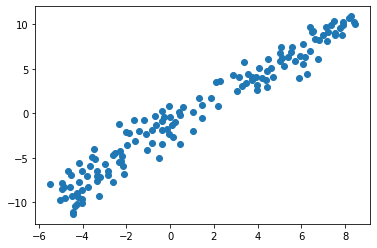

In [43]:
clean_tweets = []
for tweet_num, tweet in tweets.items(): 
        #get the terms cleaned 
        clean_tweets.append(clean_data(tweet, stopwords_bylang))

model = Word2Vec(clean_tweets, workers=4, min_count=50, window=10, sample=1e-3)

#print (model.wv.most_similar('memory'))

X = model.wv[model.wv.key_to_index]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()